# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (ie 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - 
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
# load other package
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mtl
import warnings
from imp import reload

import sys

sys.path.append("./tool/")

import preprocess

In [3]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [4]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [5]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [6]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [7]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [8]:
profile.gender.unique()

array([None, 'F', 'M', 'O'], dtype=object)

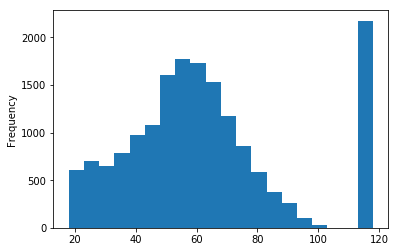

In [9]:
profile.age.plot(kind="hist", bins=20)

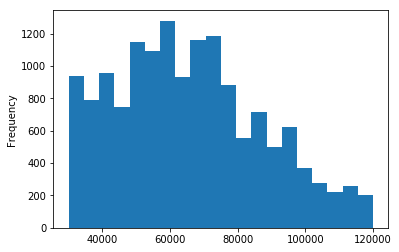

In [10]:
profile.income.plot(kind="hist", bins=20)

## Step 1: Access Data

* Portfolia data:  
    1. The attribute channels contains different channel in one cell.

* Profile data:  
    1. The attribute became_member_on is datetime type
    2. The attribute gender has None that represents a missing value. And the value O represent "ohter", the value F represent "Female", and the ohter one M represent "Male"
    3. The attribute age has abnormal value that is over 100, which maybe is the max value option

* Transcript data:  
    1. The attribute value is a dict data, which contain many information
    2. There are some duplicated values

In [11]:
# extract all channels
channels_set = set()
for i in portfolio.channels:
    channels_set.update(set(i))

In [12]:
channels_set

{'email', 'mobile', 'social', 'web'}

In [13]:
# split the channel into different attribute
for i in channels_set:
    portfolio[i] = portfolio.channels.apply(lambda x: i in x).map({True:1, False: 0})

In [14]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward,mobile,email,social,web
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,1,0,1


In [15]:
# convert the datatype into datetime
profile["became_member_on"] = pd.to_datetime(profile.became_member_on.apply(str))
profile["became_member_year"] = profile.became_member_on.dt.year
profile["became_member_month"] = profile.became_member_on.dt.month

In [16]:
# parse the information about the gender
profile["gender"] = profile.gender.map({"None":np.nan, "F":"Female", "M":"Male", "O": "Other"})

In [17]:
# fix the abnormal values about the attribute age
profile.loc[profile.age == 118, "age"] = np.nan

In [18]:
profile.head()

,age,became_member_on,gender,id,income,became_member_year,became_member_month
0,NaN,2017-02-12,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2
1,55.0,2017-07-15,Female,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7
2,NaN,2018-07-12,NaN,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018,7
3,75.0,2017-05-09,Female,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5
4,NaN,2017-08-04,NaN,a03223e636434f42ac4c3df47e8bac43,NaN,2017,8


In [19]:
# get the all kinds of the transcript type value
transcript_type = set()
for i in transcript.value:
    transcript_type.update(set(i.keys()))

In [20]:
transcript_type

{'amount', 'offer id', 'offer_id', 'reward'}

In [21]:
for i in ["amount", "reward"]:
    transcript[i] = transcript.value.apply(lambda x: x[i] if i in x else np.nan)

In [22]:
transcript["offer_id"] = transcript.value.apply(preprocess.parse_offer_id)
transcript["event"] = transcript.event.map({
    "offer completed": "offer_completed", "offer received": "offer_received",
    "offer viewed":"offer_viewed"
})

In [23]:
transcript.head()

,event,person,time,value,amount,reward,offer_id
0,offer_received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer_received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer_received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,offer_received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,offer_received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [24]:
# drop the unnessary attribute
portfolio.drop("channels", axis=1, inplace=True)
transcript.drop("value", axis=1, inplace=True)

In [25]:
# access the duplicate values
transcript.duplicated().sum(), portfolio.duplicated().sum(), profile.duplicated().sum()

(397, 0, 0)

In [26]:
# drop the duplicated value, and reset the index
transcript.drop_duplicates(inplace=True)

transcript.reset_index(drop=True, inplace=True)

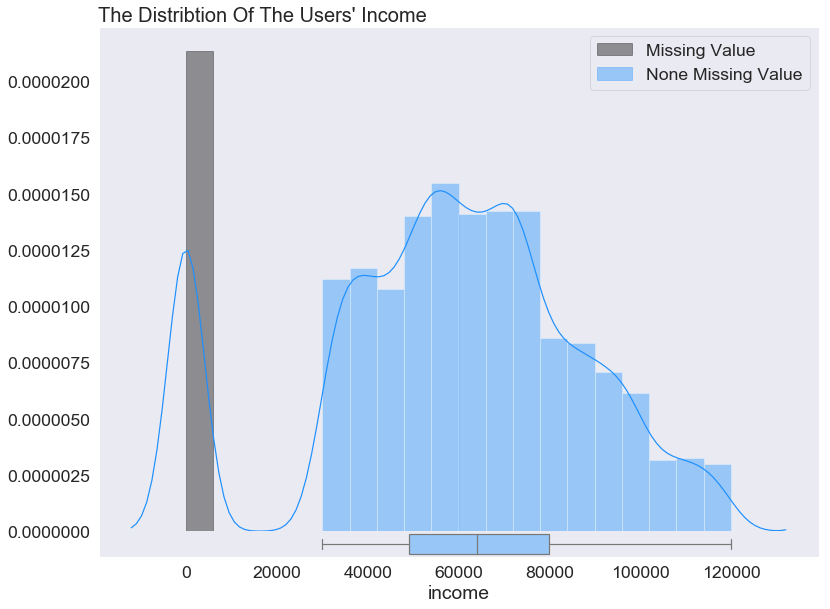

In [27]:
# deal with the income value
with warnings.catch_warnings(),sns.axes_style("dark"), sns.plotting_context("paper", font_scale=2):
    warnings.simplefilter("ignore")
    
    plt.figure(1, figsize=(10, 7))
    ax1 = plt.axes([0, 0.95, 1, .05])
    ax2 = plt.axes([0, 1, 1, 1], sharex=ax1)

    sns.boxplot(profile.loc[profile.income.notnull(), "income"], ax=ax1, color="#98C6F7", saturation=1)
    sns.distplot(profile.income.fillna(0), ax=ax2, bins=20, color="dodgerblue")

    ax2.set_xlabel("")
    ax2.tick_params(bottom=False, labelbottom=False)
    ax2.patches[0].set_color("black")
    ax2.patches[1].set_color("dodgerblue")
    ax2.patches[0].set_label("Missing Value")
    ax2.patches[1].set_label("None Missing Value")
    ax2.spines["bottom"].set_visible(False)
    ax1.spines["top"].set_visible(False)
    
    plt.title("The Distribtion Of The Users' Income", fontsize=20, loc="left")
    plt.legend()

    plt.show()

In [28]:
# split the income into four different level
profile["income_fix"] = \
    pd.qcut(profile.income, 4, labels=["low", "medium", "medium_high", "high"])

# reset the category order and fill the missing value with unknown
profile.income_fix.cat.set_categories(["unknown", "low", "medium", "medium_high", "high"], 
                                      ordered=True, inplace=True)
profile.income_fix.fillna("unknown", inplace=True)

In [29]:
profile.age.mode()[0], profile.age.mean(), profile.age.median()

(58.0, 54.39352445193929, 55.0)

In [30]:
profile.age.value_counts(dropna=False, normalize=True).nlargest(5)

NaN      0.127941
 58.0    0.024000
 53.0    0.021882
 51.0    0.021353
 59.0    0.021118
Name: age, dtype: float64

In [31]:
# deal with age missing value
profile["age_fix"] = \
    pd.qcut(profile.age, 3, labels=["young", "middle", "old"])

profile.age_fix.fillna("middle", inplace=True)

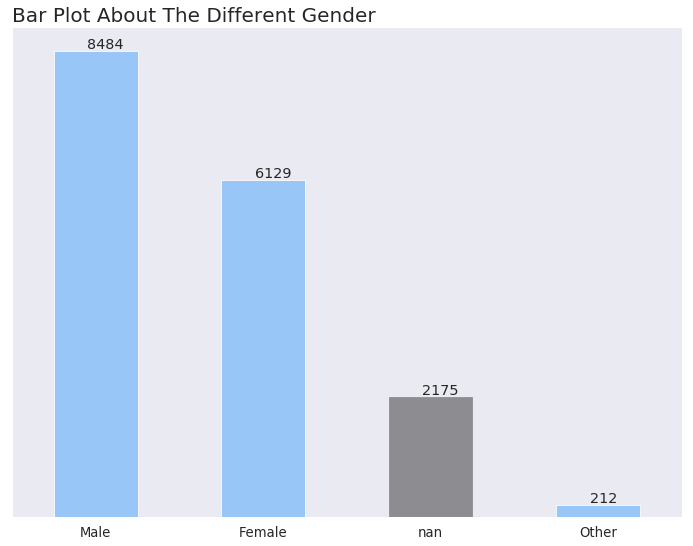

In [32]:
with sns.axes_style("dark"), sns.plotting_context("paper", font_scale=1.5):
    plt.figure(figsize=(12, 9))
    ax = plt.subplot()
    profile.gender.value_counts(dropna=False).plot(kind="bar", color="#98C6F7", rot=0)
    
    preprocess.bar_value(profile.gender.value_counts(dropna=False), xpad=-.05, ypad=50)
    
    ax.tick_params(axis="y", labelleft=False)
    ax.patches[2].set_color("#8C8C91")
    
    ax.set_title("Bar Plot About The Different Gender", loc="left", fontsize=20)

In [33]:
# fill the missing value of the gender
profile.gender.fillna("unknown", inplace=True)

## Step 2: Preprocess Data

### 2.0 Data Wrangling Simply
* Portfolia data:  
    1. Get the different channel to store in different attribute

* Profile data:  
    1. Convert the attribute became_member_on to datetime type
    2. Parse the month and the year information from the became_member_on
    3. Transfrom the attribute gender value to the original value, and fill the missing value with unknown
    4. The attribute age abnormal value translate to missing value in temporary. According to another appendix information about the users age statistics, the main users' age is between 22 - 60, which agrees with the main distribution in the data. So we use the value middle to fill the missing value
    5. The users income is a right skewness, and the number of the missing values are very large. Now we take a new to deal with the income value. Firstly, we so we divide the the user into the different income level. Secondly, we deal with the missing value as a new type.

* Transcript data:  
    1. Transform the attribute value into the different attribute
    2. Drop the duplicated values

Finally, we need to merge the dataset, then there are new some missing value need to be fixed, like offer_type, event. We create a new attribute coresponded to the original attributue, and fill the missing value:
1. The feature offer_type match the the offer_type_fix, and fill the missing value with the value No_offer
2. The feature event match the event_fix, and fill the missing value with the value offer_completed

In [34]:
portfolio.head(2)

,difficulty,duration,id,offer_type,reward,mobile,email,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1


In [35]:
profile.head(2)

,age,became_member_on,gender,id,income,became_member_year,became_member_month,income_fix,age_fix
0,NaN,2017-02-12,unknown,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,unknown,middle
1,55.0,2017-07-15,Female,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,high,middle


In [36]:
transcript.head(2)

,event,person,time,amount,reward,offer_id
0,offer_received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer_received,a03223e636434f42ac4c3df47e8bac43,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [37]:
# merge the data
data = transcript.merge(profile, how="left", left_on="person", right_on="id", validate="m:1")
data.drop("id", inplace=True, axis=1)
data = data.merge(portfolio, how="left", left_on="offer_id", right_on="id", validate="m:1",
                 suffixes=("_transcript", "_portfolia"))
data.drop("id", inplace=True, axis=1)

In [38]:
data.head(2)

,event,person,time,amount,reward_transcript,offer_id,age,became_member_on,gender,income,...,income_fix,age_fix,difficulty,duration,offer_type,reward_portfolia,mobile,email,social,web
0,offer_received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,75.0,2017-05-09,Female,100000.0,...,high,old,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
1,offer_received,a03223e636434f42ac4c3df47e8bac43,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,2017-08-04,unknown,NaN,...,unknown,middle,20.0,10.0,discount,5.0,0.0,1.0,0.0,1.0


In [39]:
data["offer_type_fix"] = data.offer_type.fillna("No_offer")
data["event_fix"] = data.event
data.loc[data.offer_id.isnull(), "event_fix"] = "No_offer_completed"

### 2.1 Analysis The Number Of Different Transanction Event With Offer
We want to caculate the number of the offer complet progress. Now we group the person, the different offer, and the offer event; at the next step, we must split the number of event by the different people and the different offer id. Before we finish the step, we use the pivot_table metho to count the number.

In [40]:
group_data = data.groupby(["person", "offer_id", "event"]).size().reset_index()
group_data.rename({0:"count"}, axis=1, inplace=True)
offer_person = group_data.pivot_table(
    index=["person", "offer_id"],  columns=["event"], values=["count"], aggfunc="count"
    ).reset_index()
offer_person.columns = ["person", "offer_id", "offer_completed", "offer_received", "offer_viewed"]

In [41]:
# fill the missing value with 0
offer_person.fillna(0, inplace=True)

In [42]:
offer_person = offer_person.merge(portfolio, left_on="offer_id", right_on="id", how="left")
offer_person.drop("id", axis=1, inplace=True)

In [43]:
offer_person.head()

,person,offer_id,offer_completed,offer_received,offer_viewed,difficulty,duration,offer_type,reward,mobile,email,social,web
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1.0,1.0,0.0,10,7,discount,2,1,1,0,1
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0,1.0,1.0,0,4,informational,0,1,1,0,1
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0,1.0,1.0,0,3,informational,0,1,1,1,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1.0,1.0,1.0,5,5,bogo,5,1,1,1,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1.0,1.0,1.0,10,10,discount,2,1,1,1,1


### 2.2 Analysis The Number Of Different Transaction Event Without Offer
At last analysis pregross, we find that there are many transaction happening without offer. So we group the uers to caculate the number of transaction in directly.

In [44]:
no_offer_person = data.loc[data.offer_id.isnull()].groupby(["person"]).size().reset_index()
no_offer_person.rename({0:"count"}, axis=1, inplace=True)

In [45]:
no_offer_person.head()

,person,count
0,0009655768c64bdeb2e877511632db8f,8
1,00116118485d4dfda04fdbaba9a87b5c,3
2,0011e0d4e6b944f998e987f904e8c1e5,5
3,0020c2b971eb4e9188eac86d93036a77,8
4,0020ccbbb6d84e358d3414a3ff76cffd,12


### 2.3 Parse The Running Time Information
During running the simulation time, we can parse the time interval between the current transaction and the last transaction

In [46]:
data["time_interval"], _ = preprocess.parse_time_value(data, "time_interval")

Pregress:100% |███████████████| Elapsed Time: 0:00:37 Time: 0:00:37   1.71 kB/s
Pregress:100% |███████████████| Elapsed Time: 0:00:15 Time: 0:00:15   1.06 kB/s


In [47]:
data.head(2).T

,0,1
event,offer_received,offer_received
person,78afa995795e4d85b5d9ceeca43f5fef,a03223e636434f42ac4c3df47e8bac43
time,0,0
amount,NaN,NaN
reward_transcript,NaN,NaN
offer_id,9b98b8c7a33c4b65b9aebfe6a799e6d9,0b1e1539f2cc45b7b9fa7c272da2e1d7
age,75,NaN
became_member_on,2017-05-09 00:00:00,2017-08-04 00:00:00
gender,Female,unknown
income,100000,NaN


## Step 3: Exploratory Data Analysis
When we finished the former steps, we can go further into the data. Now, we can use the exploratory to analyse data. Firstly, we want to know the user demographic information

In [48]:
profile.head()

,age,became_member_on,gender,id,income,became_member_year,became_member_month,income_fix,age_fix
0,NaN,2017-02-12,unknown,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,unknown,middle
1,55.0,2017-07-15,Female,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,high,middle
2,NaN,2018-07-12,unknown,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018,7,unknown,middle
3,75.0,2017-05-09,Female,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,high,old
4,NaN,2017-08-04,unknown,a03223e636434f42ac4c3df47e8bac43,NaN,2017,8,unknown,middle


In [49]:
member_amount = preprocess.members_with_time(profile.became_member_on.value_counts(), column="count", method="sum",
                                    start=profile.became_member_on.min(), end=profile.became_member_on.max()
                                    )

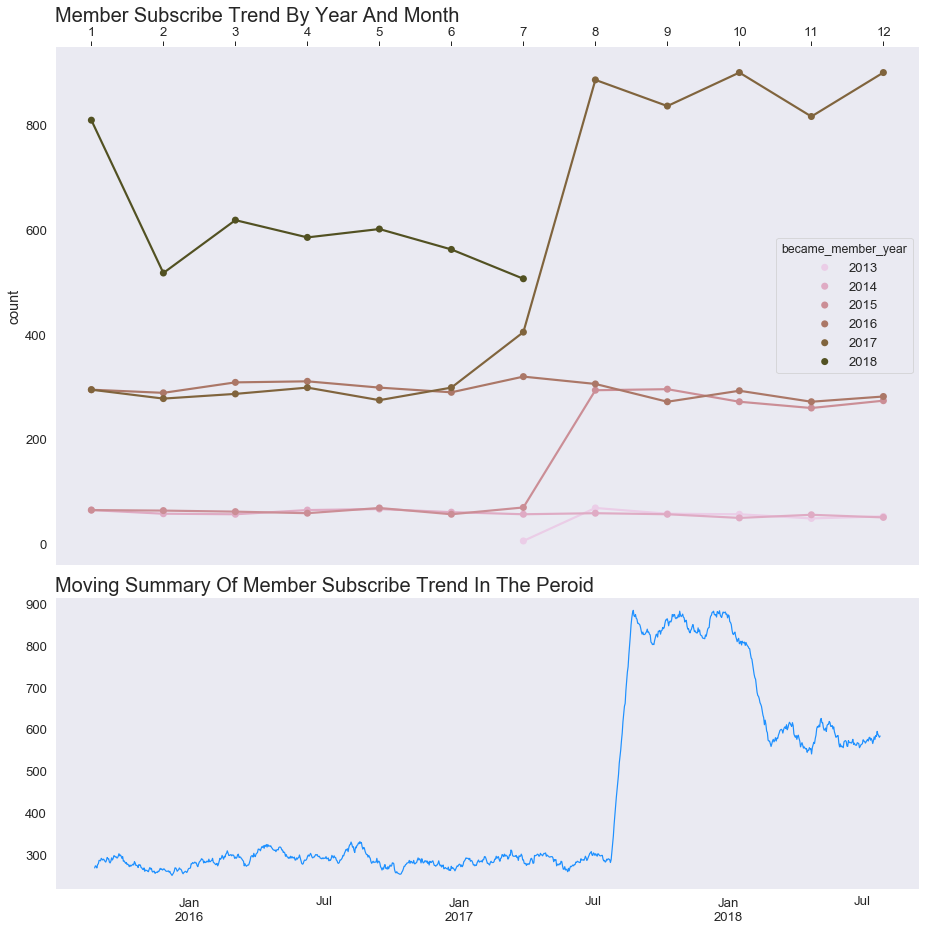

In [50]:
# deal with the income value
with warnings.catch_warnings(),sns.axes_style("dark"), sns.plotting_context("paper", font_scale=1.5):
    warnings.simplefilter("ignore")
    
    plt.figure(1, figsize=(12, 9))
    ax1 = plt.axes([0, .1, 1, .45])
    ax2 = plt.axes([0, .6, 1, .8])

    member_amount["count"].plot(kind="line", ax=ax1, color="dodgerblue")
    sns.pointplot(x="became_member_month", y="count", hue="became_member_year",
                  ax=ax2, palette=sns.color_palette("ch:2.,-.6,dark=.3"),
             data=preprocess.group_size(profile, ["became_member_year", "became_member_month"]))

    ax1.set_title("Moving Summary Of Member Subscribe Trend In The Peroid", fontsize=20, loc="left")
    ax2.tick_params(axis="x", bottom=False, labelbottom=False, top=True, labeltop=True)
    ax2.set_xlabel("")
    ax2.set_title("Member Subscribe Trend By Year And Month",
                  fontsize=20, loc="left", pad=25)


    plt.show()

### 3.1 The Member Users Subscribed Trend
Before 2017 July, almost 300 users join in the Starbucks membership in every 30 days. Then the new member trend increase at the top that is almost 900 users, between 2017 July and 2018 February. After 2018 February, the trend goes down to almost 600 users.

In [51]:
demograph_info = preprocess.group_size(data.loc[data.event_fix.isin(["offer_completed", "No_offer_completed"])],
                                       ["income_fix", "age_fix", "gender"], label="value")
demograph_info.columns = ["income", "age", "gender", "value"]

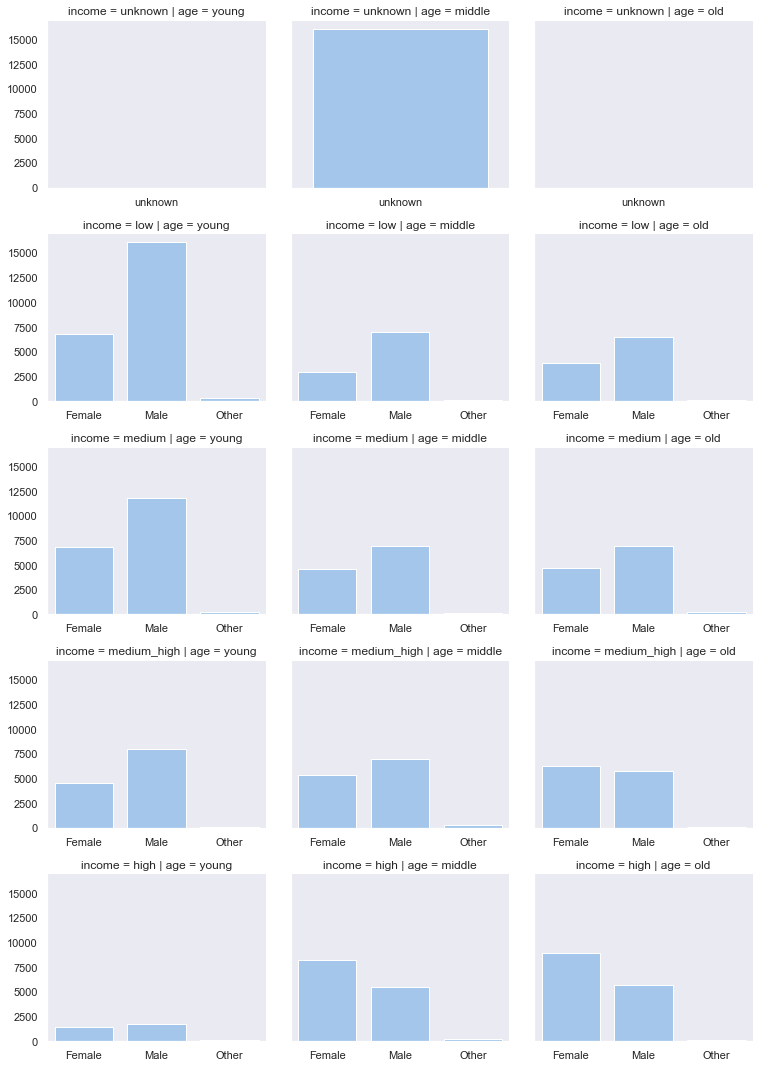

In [52]:
with sns.axes_style("dark"), sns.plotting_context("notebook", font_scale=1):
    g = sns.FacetGrid(demograph_info, row="income", col="age", aspect=1.2, sharex="row")
    g.map_dataframe(sns.barplot, x="gender", y="value", color="#98c6f7")

    plt.show()

In [53]:
(profile.groupby(["income_fix", "gender"]).size() / profile.shape[0]).nlargest(7)

income_fix   gender 
low          Male       0.155765
medium       Male       0.141529
unknown      unknown    0.127941
high         Female     0.122529
medium_high  Male       0.117412
             Female     0.092471
high         Male       0.084353
dtype: float64

### 3.2 The Useres Demographic Information
Now we know that the Starbucks users decmographic information features: the middle age male users; additionally, the high level income female is the other pop users. **Attention we just analyse the transaction completed data:**
1. The most transaction users are the middle level age, but the information of the gender and the income level is missing. Besides, the two missing demographic attribute occupy 12.79%.
2. When we control the age variable, the high income users is not the main users; but the low income users and the medium income users have the most transaction amount. Of course, the middle age uses are very common at the different the income level; whereas it is different that the high level females transaction amount is higher than the high level males. At the old age users side, the different income users are almost same; but the high income has the much more transaction amount.
3. When we control the income level variable, the young users are the primary except the high income level and the medium high level. There isn't almost different about the different age at the medium high level users. It is a pop at the high level income users except the young users.

In [54]:
data.event.value_counts(dropna=0)

NaN                138953
offer_received      76277
offer_viewed        57725
offer_completed     33182
Name: event, dtype: int64

In [55]:
demograph_info_offer = preprocess.group_size(data.loc[data.event == "offer_completed"], 
                                             ["income_fix", "age_fix", "gender", "offer_type_fix"], label="value")
demograph_info_offer.columns = ["income", "age", "gender", "offer_type", "value"]

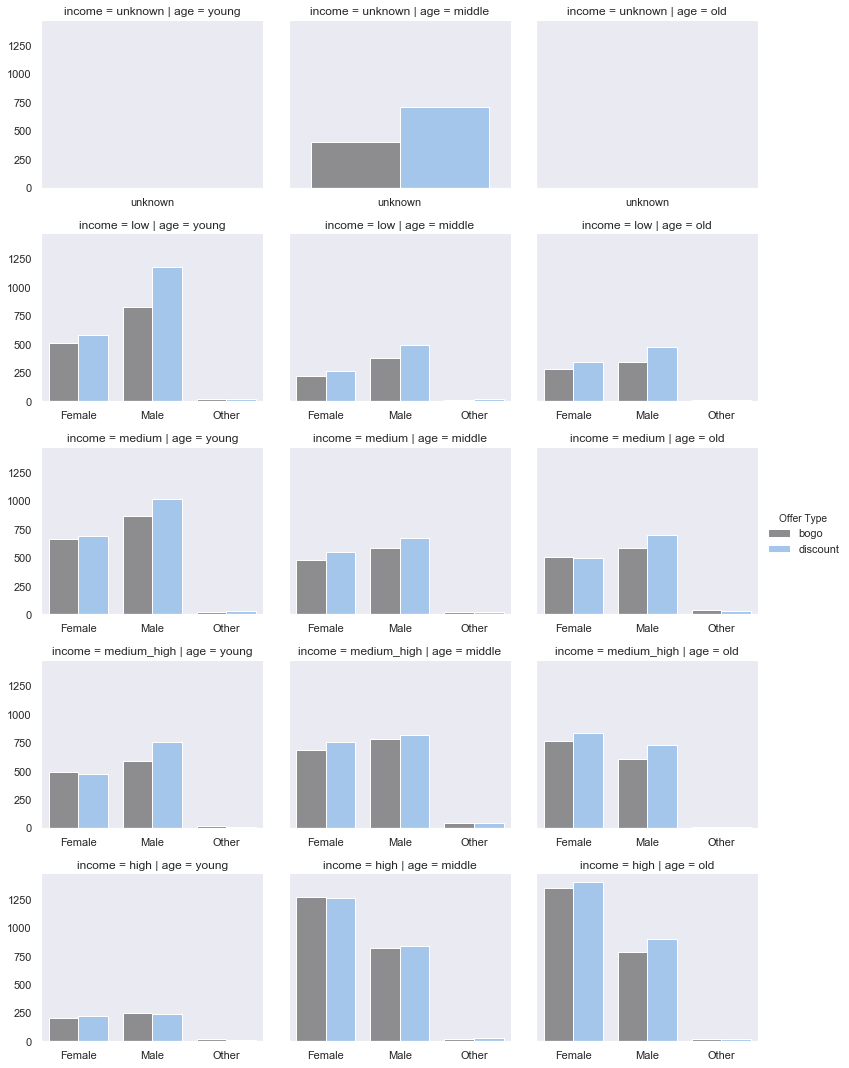

In [56]:
with sns.axes_style("dark"), sns.plotting_context("notebook", font_scale=1):
    g = sns.FacetGrid(demograph_info_offer, row="income", col="age", aspect=1.2, sharex="row")
    g.map_dataframe(sns.barplot, x="gender", y="value", hue="offer_type", palette=["#8c8c91", "#98c6f7"])
    g.add_legend(title="Offer Type")
    plt.show()

In [57]:
demograph_info_offer.nlargest(10, "value")

,income,age,gender,offer_type,value
69,high,old,Female,discount,1399
68,high,old,Female,bogo,1347
62,high,middle,Female,bogo,1269
63,high,middle,Female,discount,1260
5,low,young,Male,discount,1181
23,medium,young,Male,discount,1020
71,high,old,Male,discount,904
22,medium,young,Male,bogo,864
65,high,middle,Male,discount,842
51,medium_high,old,Female,discount,838


### 3.3 The Offer Completed Useres Demographic Information
1. Above the image, we can know that the most users make a transaction by using the discount, especially the male uses. But there is not apparently difference like the medium level income young and old female users but the medium level income female users
2. At the transaction amount, the high income users have the most number of the transaction in each type of promotion except the high income young users

In a word, the most number of the offer completed users are the high leve income users, especially the female users. From the Starbucks side, we want to know how the long-term effect is after the promotion

In [58]:
portfolio.offer_type.unique()

array(['bogo', 'informational', 'discount'], dtype=object)

### 3.4 Merge Data With Different Offer Type
There are three types promotion strategy. There is different convertion line:  
1. The BOGO type and the discount type: 
    * Offer Received => Offer Viewed => Offer Completed => Promotion Effect
    * Offer Received => Offer Completed => Promotion Effect
2. The informational type
    * Offer Received => Offer Viewed => Promotion Effect

So, we want to know what the effect is by the different promotion strategy. Now, we need to split the different offer type data, and merge with the transaction data
#### 3.4.1 The BOGO Type And The Discount Type Data

In [59]:
transcript.head(2)

,event,person,time,amount,reward,offer_id
0,offer_received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer_received,a03223e636434f42ac4c3df47e8bac43,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [60]:
portfolio.head(2)

,difficulty,duration,id,offer_type,reward,mobile,email,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1


In [61]:
data.loc[data.offer_type != "informational", "event"].value_counts()

offer_received     61042
offer_viewed       46894
offer_completed    33182
Name: event, dtype: int64

In [62]:
# get the offer_compeletion
all_offer = pd.merge(
    transcript.loc[transcript.event == "offer_received", ["person", "offer_id", "time"]],
    transcript.loc[transcript.event == "offer_completed", ["person", "offer_id", "time", "reward"]],
    how="left", on=["person", "offer_id"], suffixes=("_received", "_completed")
)


all_offer = all_offer.merge(
    portfolio, how="left", left_on="offer_id", right_on="id", suffixes=("_complete", "_offer")
)

# clean the data value about the informational data, just keep the values BOGO | discount data
offer_completion = all_offer.loc[(all_offer.offer_type != "informational")]

In [63]:
# filter the value with the validate offer duration
offer_completion = offer_completion.loc[offer_completion.apply(
            lambda x: 0 <= x["time_completed"] - x["time_received"] <= x["duration"], axis=1)]

In [64]:
offer_completion.head(2)

,person,offer_id,time_received,time_completed,reward_complete,difficulty,duration,id,offer_type,reward_offer,mobile,email,social,web
39,676506bad68e4161b9bbaffeb039626b,ae264e3637204a6fb9bb56bc8210ddfd,0,0.0,10.0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
40,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,2906b810c7d4411798c6938adc9daaa5,0,0.0,2.0,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1


In [65]:
# merge the transaction data after the non informational promotion
validate_offer_data = pd.merge(
        transcript.loc[transcript.offer_id.isnull(), ["person", "time", "amount"]],
        offer_completion.loc[:, ["person", "offer_id", "time_received", 
                                 "time_completed", "duration", "reward_complete"]],
        on="person", how="left", suffixes=("_purchase", "_offer")
    )

In [66]:
# filter the purchase data after the non informational promotion
after_offer = validate_offer_data.loc[validate_offer_data.apply(lambda x: (x["time"] > x["time_completed"] and \
                                                 (x["time_received"] + x["duration"] <= x["time"])), axis=1)]

In [67]:
after_offer.head(2)

,person,time,amount,offer_id,time_received,time_completed,duration,reward_complete
713,8f7dd3b2afe14c078eb4f6e6fe4ba97d,6,16.03,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0.0,5.0,10.0
761,5152fa6375184287b06e2fd0d5abed34,6,15.53,f19421c1d4aa40978ebb69ca19b0e20d,0.0,0.0,5.0,5.0


In [68]:
after_offer.person.nunique(), after_offer.offer_id.nunique()

(2903, 8)

In [69]:
portfolio[~portfolio.id.isin(after_offer.offer_id.unique())]

,difficulty,duration,id,offer_type,reward,mobile,email,social,web
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0


#### 3.4.2 The Informational Data

In [70]:
# get the informational promotion vaue
all_info = preprocess.merge_data(
        transcript, transcript, condition="event", cond_value1="offer_viewed",
        cond_value2="offer_received", columns1=["person", "offer_id", "time"], 
        columns2=["person", "offer_id", "time", "reward"], how="left",
        on=["person", "offer_id"], suffixes=("_viewed", "_received"),
         portfolio=portfolio, portfolio_suffix=("_info", "_offer")
    )

# Store the data value with the informational data
info_completion = all_info.loc[(all_info.offer_type == "informational")]

In [71]:
# filter the validate value with the informational duration
info_completion = info_completion.loc[info_completion.apply(
            lambda x: 0 <= x["time_received"] - x["time_viewed"] <= x["duration"], axis=1)]

In [72]:
info_completion.head(2)

,person,offer_id,time_viewed,time_received,difficulty,duration,id,offer_type,reward_offer,mobile,email,social,web
2,d1ede868e29245ea91818a903fec04c6,5a8bc65990b245e5a138643cd4eb9837,0,0,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0
5,be8a5d1981a2458d90b255ddc7e0d174,5a8bc65990b245e5a138643cd4eb9837,0,0,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0


In [73]:
# merge the transaction data after the informational promotion
validate_info_data = preprocess.merge_data(
    transcript.loc[transcript.offer_id.isnull(), ["person", "time", "amount"]],
    info_completion.loc[:, ["person", "offer_id", "time_received", "time_viewed",
                            "duration"]], portfolio_suffix=("_purchase", "_info"),
    on="person"
    )

In [74]:
# filter the purchase data after the non informational promotion
after_info = validate_info_data.loc[validate_info_data.apply(preprocess.info_filter, axis=1)]

# unify the finish time :change the time_viewed to the time_completed
after_info = after_info.rename({"time_viewed" : "time_completed"}, axis=1)

In [75]:
after_info.head(2)

,person,time,amount,offer_id,time_received,time_completed,duration
639,be8a5d1981a2458d90b255ddc7e0d174,6,2.63,5a8bc65990b245e5a138643cd4eb9837,0.0,0.0,3.0
642,e737ff591120415581ddbe817b8c82ca,6,23.27,5a8bc65990b245e5a138643cd4eb9837,0.0,0.0,3.0


In [76]:
after_offer.head(2)

,person,time,amount,offer_id,time_received,time_completed,duration,reward_complete
713,8f7dd3b2afe14c078eb4f6e6fe4ba97d,6,16.03,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0.0,5.0,10.0
761,5152fa6375184287b06e2fd0d5abed34,6,15.53,f19421c1d4aa40978ebb69ca19b0e20d,0.0,0.0,5.0,5.0


##### 3.4.3 Merge The Different Type Data
Now we get the different promotion strategy data, then we must merge the two datasets. After finishing the process, we can go to analyse the effect of the different promotion strategy data

In [77]:
after_promotion = \
    pd.concat([after_offer[["person", "offer_id", "time", "time_completed", "amount", "reward_complete"]], 
           after_info[["person", "offer_id", "time", "time_completed", "amount"]]], 
              sort=False).reset_index(drop=1)

In [78]:
after_promotion.shape

(28217, 6)

In [79]:
after_promotion.head(2)

,person,offer_id,time,time_completed,amount,reward_complete
0,8f7dd3b2afe14c078eb4f6e6fe4ba97d,4d5c57ea9a6940dd891ad53e9dbe8da0,6,0.0,16.03,10.0
1,5152fa6375184287b06e2fd0d5abed34,f19421c1d4aa40978ebb69ca19b0e20d,6,0.0,15.53,5.0


In [80]:
profile.head(2)

,age,became_member_on,gender,id,income,became_member_year,became_member_month,income_fix,age_fix
0,NaN,2017-02-12,unknown,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,unknown,middle
1,55.0,2017-07-15,Female,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,high,middle


In [81]:
portfolio.head(2)

,difficulty,duration,id,offer_type,reward,mobile,email,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1


In [82]:
# merge the all data

# firstly merge the profile data
after_promotion = preprocess.merge_data(
        profile.rename({"id":"person"}, axis=1).iloc[:, np.r_[1:4, 5:9]], 
        after_promotion, how="right", on="person", portfolio_suffix=("_x", "_y")
    )
# secondly merge with the porfolio data
after_promotion = preprocess.merge_data(
        portfolio.rename({"id":"offer_id"}, axis=1),
        after_promotion, how="right", on="offer_id", portfolio_suffix=("_x", "_y")
    )

In [ ]:
reload(preprocess)

In [ ]:
data.loc[data.event.isnull()].notnull().sum()

从上面的两行代码可以看出有使用优惠的数据是没有进行现金交易的，没有使用优惠的数据是全部是有进行现金交易的

In [ ]:
transcript.event.unique()

In [ ]:
data.loc[(data.offer_type != "informational") & (data.event == "offer_received")].shape

In [ ]:
test = data.loc[data.offer_type != "informational"] \
    .groupby(["person", "offer_id", "event"]).filter(lambda x: len(x["time"]) >= 2)

In [ ]:
test1 = (test.groupby(["person", "offer_id"])["time"].max() - 
            test.groupby(["person", "offer_id"])["time"].min()).reset_index()

In [ ]:
test1["duration"] = test1.offer_id.replace(portfolio.set_index("id")["duration"])

In [ ]:
test1.person.nunique()

In [ ]:
test1.loc[test1.time <= test1.duration, :]

In [ ]:
data.loc[data.offer_type == "informational"].groupby(["person", "offer_id"]).size()

In [ ]:
data.groupby(["person", "offer_id", "event"]).filter(lambda x: len(x) > 2)

## A. Reference
1. [Starbucks Demographics and Consumer Insights](http://snapshot.numerator.com/brand/starbucks)
2. [30 Curious Starbucks Demographics](https://brandongaille.com/30-curious-starbucks-demographics/)
3. [Who Is Starbucks' Target Audience?](https://smallbusiness.chron.com/starbucks-target-audience-10553.html)
4. [机器学习中如何处理缺失数据](https://blog.csdn.net/hai008007/article/details/80067865)